In [ ]:
# %pip install scikit-learn pandas seaborn matplotlib

^C
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder



In [ ]:
def check_empty_df(df: pd.DataFrame) -> bool:
    if df.empty or df.shape[1] == 0:
        return True
    return False


In [ ]:
def get_plot(df: pd.DataFrame, column: str, bins: int = 30, kind: str = 'hist', color: str = 'skyblue', edgecolor: str = 'black', alpha: float = 0.7, kde: bool = False) -> None:
    """
    Plots a histogram or a normal (KDE) plot for a DataFrame column.
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    column : str
        The column to plot.
    bins : int, default=30
        Number of bins for the plot.
    kind : {'hist', 'kde'}, default='hist'
        Kind of the plot. Possible values:
        - 'hist' -> histogram.
        - 'kde' -> kernel density estimate (normal curve).
    color : str, default='skyblue'
        Color of the bars/line.
    edgecolor : str, default='black'
        Color of the bar edges.
    alpha : float, default=0.7
        Transparency of the bars/line.
    kde : bool, default=False
        If True, overlays a KDE curve on the plot.
    ----------
    """
    data = df[column].dropna()
    plt.figure(figsize=(8, 5))
    if kind == 'hist':
        plt.hist(data, bins=bins, color=color, edgecolor=edgecolor, alpha=alpha, density=True)
        if kde:
            sns.kdeplot(data, color='red', linewidth=2)
        plt.title(f"Histogram of {column}")
        plt.xlabel(column[0].upper() + column[1:])
        plt.ylabel("Density")
    elif kind == 'kde':
        sns.kdeplot(data, color=color, linewidth=2, fill=True, alpha=alpha)
        plt.title(f"KDE (Normal Curve) of {column}")
        plt.xlabel(column[0].upper() + column[1:])
        plt.ylabel("Density")
    plt.show()

def fill_na(df: pd.DataFrame, approach: str = 'mean', **args) -> pd.DataFrame:
    """
    Completes missing values in a DataFrame with chosen approach.

    Parameters
    ----------

    df : pd.DataFrame
        The DataFrame containing the data.
    approach : {'knn', 'hist'}, default='mean'
        An approach that will be used to fill in missing values. Possible values:
        - 'knn' -> Completing missing values using k-Nearest Neighbors
        - 'mean' -> Compleating missing values using column's mean
    column : str
        Only write if there is a need to fill a specific column.
    n_neighbors : int, default=5
        Number of neighboring samples to use for imputation.
    
    ----------
    
    Returns
    -------
    pd.DataFrame with completed missing values
    """
    
    if check_empty_df(df):
        raise ValueError("DataFrame has no columns.")
    

    column = args.get('column')
    if column is not None and column not in df.columns:
        raise KeyError(f"Column '{column}' does not exist in DataFrame.")
    
    approaches = {
        'knn': fill_na_knn(df, column=column, n_neighbors=args.get('n_neighbors', 5)),
        'mean': fill_na_mean(df, column) if column else df
    }
    if approach in approaches:
        return approaches[approach]
    else:
        raise ValueError(f"Unknown approach: {approach}")

def fill_na_mean(df : pd.DataFrame, column : str) -> pd.DataFrame:
    """
    Fills missing values using mean

    Parameters
    ----------

    df : pd.DataFrame
        The DataFrame containing the data.
    column : str
        The column with missing values
    
    ----------

    
    Returns
    -------
    pd.DataFrame with completed missing values

    """
    mean_value = df[column].mean()
    column_filled = df.copy()[column].fillna(mean_value)
    df[column] = column_filled
    return df

def fill_na_knn(df:pd.DataFrame, column: str | None = None, n_neighbors : int = 5) -> pd.DataFrame:
    """
    Fills missing values using k-Nearest Neighbors.

    Parameters
    ----------
    
    df : pd.DataFrame
        The DataFrame containing the data.
    column : str, default=None
        The column with missing values.
    n_neighbors : int, default=5
        Number of neighboring samples to use for imputation.
    
    ----------

    
    Returns
    -------
    pd.DataFrame with completed missing values
    """
    if check_empty_df(df):
        raise ValueError("DataFrame has no columns for KNN imputation.")
    
    
    df_filled = df.copy()
    df_numerical = df_filled.select_dtypes(include=['int64', 'float64'])
    if check_empty_df(df_numerical):
        raise ValueError("No numerical columns available for KNN imputation.")
    
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_array = imputer.fit_transform(df_numerical)
    
    df_imputed = pd.DataFrame(df_array, index=df_numerical.index, columns=df_numerical.columns)
    if column:
        df_filled[column] = df_imputed[column]
    else:
        df_filled.update(df_imputed)
    return df_filled


In [25]:
def delete_column(df, column: str) -> pd.DataFrame:
    return df.copy().drop(columns=[column])

def delete_row(df, row_id) -> pd.DataFrame:
    return df.copy().drop([row_id])

def change_cell_value(df: pd.DataFrame, column: str, row_id: int, new_value: str | int | float)-> pd.DataFrame:
    df_changed = df.copy()
    df_changed.loc[column,row_id] = new_value
    return df_changed

def get_rows(df: pd.DataFrame, start_row: int, end_row: int) -> pd.DataFrame:
    return df.iloc[start_row:end_row]

def get_data(file_name:str) -> pd.DataFrame:
    file_type = file_name.split('.')[-1]
    file_types = {
        'csv': pd.read_csv, 
        'excel':pd.read_excel, 
        'json': pd.read_json,
        'xml': pd.read_xml,
        'html': pd.read_html,
        'sql': pd.read_sql
        }
    if file_type.lower() in list(file_types.keys()):
        df = file_types[file_type.lower()](file_name)
        return df
    else: 
        raise TypeError(f'Try using one of the supported file types:\n{', '.join(list(file_types.keys()))}')

def save_data(df: pd.DataFrame, file_name: str, file_type: str = 'csv', index:bool = True) -> None:
    file_types = {
        'csv': df.to_csv, 
        'excel':df.to_excel, 
        'json': df.to_json,
        'xml': df.to_xml,
        'html': df.to_html,
        'sql': df.to_sql
        }
    
    if file_type.lower() in list(file_types.keys()):
        file_types[file_type.lower()](file_name+f'.{file_type}', index=index)
    else: 
        raise TypeError(f'Try using one of the supported file types:\n{', '.join(list(file_types.keys()))}')


In [18]:
df_init = sns.load_dataset('titanic')

In [19]:
df_init.select_dtypes(include=['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   age       714 non-null    float64
 3   sibsp     891 non-null    int64  
 4   parch     891 non-null    int64  
 5   fare      891 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 41.9 KB


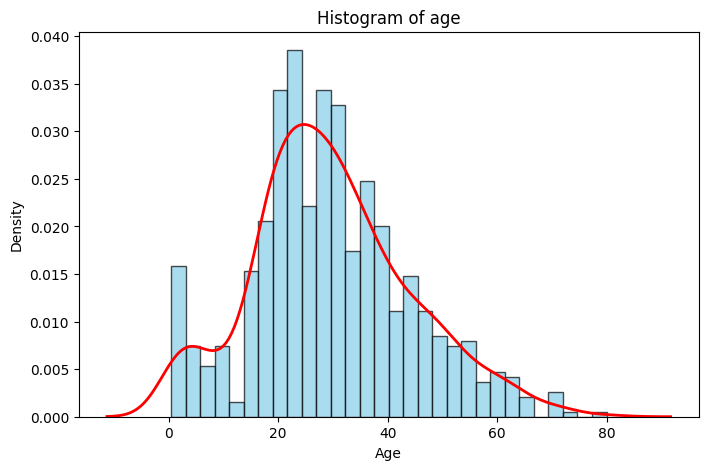

In [39]:
get_plot(df_init, 'age', kde=True)

In [20]:
df = df_init.copy()

In [22]:
df_filled_age = fill_na(df, 'knn', column='age').select_dtypes(include=['int64', 'float64'])

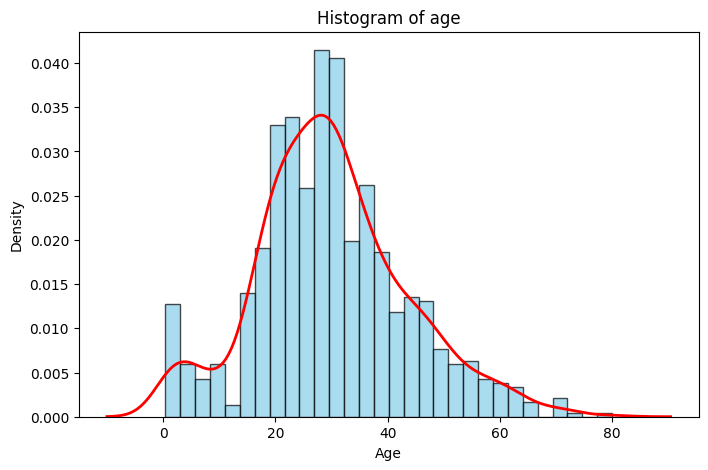

In [37]:
get_plot(df_filled_age, 'age', kde=True)

In [ ]:
# TODO: finish pipeline: category/object -> encoded -> fill_na -> decoded
def get_encoded_object_columns(df: pd.DataFrame) -> dict:

    encoders = {}
    object_df = pd.DataFrame(index=df.index)

    df_temp = df.copy()
    object_columns = df_temp.select_dtypes(include=['object']).columns
    for column in object_columns:
        series = df_temp[column]
        encoder = LabelEncoder()
        encoder.fit(series.dropna())
        encoders[column] = encoder

        encoded = series.map(lambda x: encoder.transform([x])[0] if pd.notnull(x) else np.nan)
        object_df[column + '_encoded'] = encoded

    return {'encoded': object_df, 'encoders': encoders}

In [43]:
test_output = get_encoded_object_columns(df)

In [44]:
test_output

{'encoded':      sex_encoded  embarked_encoded  who_encoded  embark_town_encoded  \
 0              1               2.0            1                  2.0   
 1              0               0.0            2                  0.0   
 2              0               2.0            2                  2.0   
 3              0               2.0            2                  2.0   
 4              1               2.0            1                  2.0   
 ..           ...               ...          ...                  ...   
 886            1               2.0            1                  2.0   
 887            0               2.0            2                  2.0   
 888            0               2.0            2                  2.0   
 889            1               0.0            1                  0.0   
 890            1               1.0            1                  1.0   
 
      alive_encoded  
 0                0  
 1                1  
 2                1  
 3                1  
 

In [56]:
def get_decoded_columns(encoded_df : pd.DataFrame, encoders: dict) -> pd.DataFrame :
    decoded_df = pd.DataFrame()
    for column in encoded_df.columns:
        series = encoded_df[column]

        original_column_name = column.removesuffix('_encoded')
        encoder = encoders[original_column_name]
        
        decoded = series.map(lambda x: encoder.inverse_transform([int(x)])[0] if pd.notnull(x) else np.nan)
        decoded_df[original_column_name + '_decoded'] = decoded

    return decoded_df

In [57]:
# decoded = encoded.map(lambda x: encoder.inverse_transform([int(x)])[0] if pd.notnull(x) else np.nan)
# df_work[column + '_decoded'] = decoded

In [58]:
encoded_df = test_output['encoded']

In [59]:
decode_output = get_decoded_columns(test_output['encoded'], test_output['encoders'])

In [60]:
decode_output

,sex_decoded,embarked_decoded,who_decoded,embark_town_decoded,alive_decoded
0,male,S,man,Southampton,no
1,female,C,woman,Cherbourg,yes
2,female,S,woman,Southampton,yes
3,female,S,woman,Southampton,yes
4,male,S,man,Southampton,no
...,...,...,...,...,...
886,male,S,man,Southampton,no
887,female,S,woman,Southampton,yes
888,female,S,woman,Southampton,no
889,male,C,man,Cherbourg,yes
